# Spatial mapping of cell types across the mouse brain (1/3) - estimating reference expression signatures of cell types

This notebook demonstrates how to use the **cell2location** model for mapping a single cell reference cell types onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain ([Kleshchevnikov et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1)). 

Cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and
multi-cell spatial transcriptomics to efficiently map large and comprehensive cell type references (Fig 1). 

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*

In the first step covered by this notebook (#2 in Fig 1), we estimate reference cell type signatures from scRNA-seq profiles, for example as obtained using conventional clustering to identify cell types and subpopulations followed by estimation of average cluster gene expression profiles ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). Cell2location implements this estimation step based on Negative Binomial regression, which allows to robustly combine data across technologies and batches ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf)).

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)


## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). This datasets consists of cells coming from 3 sections from 2 mice each. We have annotated 59 cell neuronal and glial populations across multiple brain regions, including 10 subtypes of regional astrocytes.

First we need to load the data from our data portal:

In [2]:
sc_data_folder = './data/'
results_folder = './results/mouse_brain_snrna/'

In [3]:
if os.path.exists(sc_data_folder) is not True:
    os.mkdir(sc_data_folder)
os.system(f'cd {sc_data_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/all_cells_20200625.h5ad')
os.system(f'cd {sc_data_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/snRNA_annotation_astro_subtypes_refined59_20200823.csv')


if os.path.exists(results_folder) is not True:
    os.mkdir('./results')
    os.mkdir(results_folder)

--2021-08-22 09:02:30--  https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/all_cells_20200625.h5ad
Resolving wwwcache.sanger.ac.uk (wwwcache.sanger.ac.uk)... 172.30.152.200
Connecting to wwwcache.sanger.ac.uk (wwwcache.sanger.ac.uk)|172.30.152.200|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 732127109 (698M) [application/octet-stream]
Saving to: ‘all_cells_20200625.h5ad.7’

     0K .......... .......... .......... .......... ..........  0% 68.0M 10s
    50K .......... .......... .......... .......... ..........  0% 22.1M 21s
   100K .......... .......... .......... .......... ..........  0% 35.6M 21s
   150K .......... .......... .......... .......... ..........  0% 36.0M 20s
   200K .......... .......... .......... .......... ..........  0% 75.8M 18s
   250K .......... .......... .......... .......... ..........  0% 32.1M 19s
   300K .......... .......... .......... .......... ..........  0% 24.3M 20s
   350K .......... .......... .......

 10200K .......... .......... .......... .......... ..........  1%  118M 11s
 10250K .......... .......... .......... .......... ..........  1%  119M 10s
 10300K .......... .......... .......... .......... ..........  1%  104M 10s
 10350K .......... .......... .......... .......... ..........  1% 96.3M 10s
 10400K .......... .......... .......... .......... ..........  1%  116M 10s
 10450K .......... .......... .......... .......... ..........  1%  115M 10s
 10500K .......... .......... .......... .......... ..........  1%  123M 10s
 10550K .......... .......... .......... .......... ..........  1% 98.1M 10s
 10600K .......... .......... .......... .......... ..........  1%  127M 10s
 10650K .......... .......... .......... .......... ..........  1%  114M 10s
 10700K .......... .......... .......... .......... ..........  1%  116M 10s
 10750K .......... .......... .......... .......... ..........  1% 85.3M 10s
 10800K .......... .......... .......... .......... ..........  1%  115M 10s

 32900K .......... .......... .......... .......... ..........  4%  250M 7s
 32950K .......... .......... .......... .......... ..........  4%  235M 7s
 33000K .......... .......... .......... .......... ..........  4%  258M 7s
 33050K .......... .......... .......... .......... ..........  4% 34.2M 7s
 33100K .......... .......... .......... .......... ..........  4%  188M 7s
 33150K .......... .......... .......... .......... ..........  4%  158M 7s
 33200K .......... .......... .......... .......... ..........  4%  170M 7s
 33250K .......... .......... .......... .......... ..........  4%  192M 7s
 33300K .......... .......... .......... .......... ..........  4% 44.5M 7s
 33350K .......... .......... .......... .......... ..........  4%  178M 7s
 33400K .......... .......... .......... .......... ..........  4%  197M 7s
 33450K .......... .......... .......... .......... ..........  4%  201M 7s
 33500K .......... .......... .......... .......... ..........  4%  200M 7s
 33550K ....

 55700K .......... .......... .......... .......... ..........  7%  248M 7s
 55750K .......... .......... .......... .......... ..........  7%  225M 7s
 55800K .......... .......... .......... .......... ..........  7% 34.6M 7s
 55850K .......... .......... .......... .......... ..........  7%  201M 7s
 55900K .......... .......... .......... .......... ..........  7%  187M 7s
 55950K .......... .......... .......... .......... ..........  7%  151M 7s
 56000K .......... .......... .......... .......... ..........  7%  185M 7s
 56050K .......... .......... .......... .......... ..........  7% 44.2M 7s
 56100K .......... .......... .......... .......... ..........  7%  193M 7s
 56150K .......... .......... .......... .......... ..........  7%  169M 7s
 56200K .......... .......... .......... .......... ..........  7%  185M 7s
 56250K .......... .......... .......... .......... ..........  7%  185M 7s
 56300K .......... .......... .......... .......... ..........  7%  186M 7s
 56350K ....

 78400K .......... .......... .......... .......... .......... 10% 40.4M 6s
 78450K .......... .......... .......... .......... .......... 10%  211M 6s
 78500K .......... .......... .......... .......... .......... 10%  268M 6s
 78550K .......... .......... .......... .......... .......... 10%  239M 6s
 78600K .......... .......... .......... .......... .......... 11%  275M 6s
 78650K .......... .......... .......... .......... .......... 11% 46.7M 6s
 78700K .......... .......... .......... .......... .......... 11%  135M 6s
 78750K .......... .......... .......... .......... .......... 11%  120M 6s
 78800K .......... .......... .......... .......... .......... 11%  158M 6s
 78850K .......... .......... .......... .......... .......... 11%  155M 6s
 78900K .......... .......... .......... .......... .......... 11% 61.2M 6s
 78950K .......... .......... .......... .......... .......... 11%  121M 6s
 79000K .......... .......... .......... .......... .......... 11%  143M 6s
 79050K ....

101250K .......... .......... .......... .......... .......... 14%  246M 6s
101300K .......... .......... .......... .......... .......... 14%  250M 6s
101350K .......... .......... .......... .......... .......... 14%  232M 6s
101400K .......... .......... .......... .......... .......... 14%  261M 6s
101450K .......... .......... .......... .......... .......... 14% 20.5M 6s
101500K .......... .......... .......... .......... .......... 14%  186M 6s
101550K .......... .......... .......... .......... .......... 14%  152M 6s
101600K .......... .......... .......... .......... .......... 14%  174M 6s
101650K .......... .......... .......... .......... .......... 14%  183M 6s
101700K .......... .......... .......... .......... .......... 14%  187M 6s
101750K .......... .......... .......... .......... .......... 14%  172M 6s
101800K .......... .......... .......... .......... .......... 14%  200M 6s
101850K .......... .......... .......... .......... .......... 14%  190M 6s
101900K ....

124100K .......... .......... .......... .......... .......... 17%  249M 6s
124150K .......... .......... .......... .......... .......... 17%  278M 6s
124200K .......... .......... .......... .......... .......... 17%  253M 6s
124250K .......... .......... .......... .......... .......... 17% 48.8M 6s
124300K .......... .......... .......... .......... .......... 17%  178M 6s
124350K .......... .......... .......... .......... .......... 17%  199M 6s
124400K .......... .......... .......... .......... .......... 17%  171M 6s
124450K .......... .......... .......... .......... .......... 17%  216M 6s
124500K .......... .......... .......... .......... .......... 17% 30.1M 6s
124550K .......... .......... .......... .......... .......... 17%  249M 6s
124600K .......... .......... .......... .......... .......... 17%  203M 6s
124650K .......... .......... .......... .......... .......... 17%  115M 6s
124700K .......... .......... .......... .......... .......... 17%  222M 6s
124750K ....

146900K .......... .......... .......... .......... .......... 20%  271M 5s
146950K .......... .......... .......... .......... .......... 20%  268M 5s
147000K .......... .......... .......... .......... .......... 20%  247M 5s
147050K .......... .......... .......... .......... .......... 20% 31.8M 5s
147100K .......... .......... .......... .......... .......... 20%  215M 5s
147150K .......... .......... .......... .......... .......... 20%  209M 5s
147200K .......... .......... .......... .......... .......... 20%  182M 5s
147250K .......... .......... .......... .......... .......... 20%  220M 5s
147300K .......... .......... .......... .......... .......... 20% 42.1M 5s
147350K .......... .......... .......... .......... .......... 20%  221M 5s
147400K .......... .......... .......... .......... .......... 20%  181M 5s
147450K .......... .......... .......... .......... .......... 20%  225M 5s
147500K .......... .......... .......... .......... .......... 20%  228M 5s
147550K ....

169800K .......... .......... .......... .......... .......... 23% 33.8M 5s
169850K .......... .......... .......... .......... .......... 23%  205M 5s
169900K .......... .......... .......... .......... .......... 23%  198M 5s
169950K .......... .......... .......... .......... .......... 23%  203M 5s
170000K .......... .......... .......... .......... .......... 23%  174M 5s
170050K .......... .......... .......... .......... .......... 23% 34.2M 5s
170100K .......... .......... .......... .......... .......... 23%  190M 5s
170150K .......... .......... .......... .......... .......... 23%  189M 5s
170200K .......... .......... .......... .......... .......... 23%  179M 5s
170250K .......... .......... .......... .......... .......... 23%  196M 5s
170300K .......... .......... .......... .......... .......... 23% 46.2M 5s
170350K .......... .......... .......... .......... .......... 23%  240M 5s
170400K .......... .......... .......... .......... .......... 23%  206M 5s
170450K ....

192600K .......... .......... .......... .......... .......... 26% 29.6M 5s
192650K .......... .......... .......... .......... .......... 26%  198M 5s
192700K .......... .......... .......... .......... .......... 26%  250M 5s
192750K .......... .......... .......... .......... .......... 26%  260M 5s
192800K .......... .......... .......... .......... .......... 26%  218M 5s
192850K .......... .......... .......... .......... .......... 26%  256M 5s
192900K .......... .......... .......... .......... .......... 26% 37.3M 5s
192950K .......... .......... .......... .......... .......... 26%  196M 5s
193000K .......... .......... .......... .......... .......... 27%  176M 5s
193050K .......... .......... .......... .......... .......... 27%  195M 5s
193100K .......... .......... .......... .......... .......... 27%  195M 5s
193150K .......... .......... .......... .......... .......... 27% 43.0M 5s
193200K .......... .......... .......... .......... .......... 27%  167M 5s
193250K ....

215400K .......... .......... .......... .......... .......... 30% 33.1M 5s
215450K .......... .......... .......... .......... .......... 30%  232M 5s
215500K .......... .......... .......... .......... .......... 30%  238M 5s
215550K .......... .......... .......... .......... .......... 30%  235M 5s
215600K .......... .......... .......... .......... .......... 30%  200M 5s
215650K .......... .......... .......... .......... .......... 30% 53.3M 5s
215700K .......... .......... .......... .......... .......... 30%  160M 5s
215750K .......... .......... .......... .......... .......... 30%  170M 5s
215800K .......... .......... .......... .......... .......... 30%  159M 5s
215850K .......... .......... .......... .......... .......... 30%  182M 5s
215900K .......... .......... .......... .......... .......... 30% 44.4M 5s
215950K .......... .......... .......... .......... .......... 30%  125M 5s
216000K .......... .......... .......... .......... .......... 30%  142M 5s
216050K ....

238250K .......... .......... .......... .......... .......... 33% 29.4M 4s
238300K .......... .......... .......... .......... .......... 33%  236M 4s
238350K .......... .......... .......... .......... .......... 33%  261M 4s
238400K .......... .......... .......... .......... .......... 33%  230M 4s
238450K .......... .......... .......... .......... .......... 33%  281M 4s
238500K .......... .......... .......... .......... .......... 33%  281M 4s
238550K .......... .......... .......... .......... .......... 33% 40.4M 4s
238600K .......... .......... .......... .......... .......... 33%  246M 4s
238650K .......... .......... .......... .......... .......... 33%  263M 4s
238700K .......... .......... .......... .......... .......... 33%  237M 4s
238750K .......... .......... .......... .......... .......... 33%  263M 4s
238800K .......... .......... .......... .......... .......... 33% 43.3M 4s
238850K .......... .......... .......... .......... .......... 33%  188M 4s
238900K ....

261300K .......... .......... .......... .......... .......... 36%  269M 4s
261350K .......... .......... .......... .......... .......... 36% 34.5M 4s
261400K .......... .......... .......... .......... .......... 36%  187M 4s
261450K .......... .......... .......... .......... .......... 36%  199M 4s
261500K .......... .......... .......... .......... .......... 36%  261M 4s
261550K .......... .......... .......... .......... .......... 36%  271M 4s
261600K .......... .......... .......... .......... .......... 36% 38.0M 4s
261650K .......... .......... .......... .......... .......... 36%  208M 4s
261700K .......... .......... .......... .......... .......... 36%  200M 4s
261750K .......... .......... .......... .......... .......... 36%  199M 4s
261800K .......... .......... .......... .......... .......... 36%  184M 4s
261850K .......... .......... .......... .......... .......... 36% 45.6M 4s
261900K .......... .......... .......... .......... .......... 36%  183M 4s
261950K ....

284200K .......... .......... .......... .......... .......... 39% 34.7M 4s
284250K .......... .......... .......... .......... .......... 39%  259M 4s
284300K .......... .......... .......... .......... .......... 39%  270M 4s
284350K .......... .......... .......... .......... .......... 39%  277M 4s
284400K .......... .......... .......... .......... .......... 39%  234M 4s
284450K .......... .......... .......... .......... .......... 39% 35.7M 4s
284500K .......... .......... .......... .......... .......... 39%  250M 4s
284550K .......... .......... .......... .......... .......... 39%  211M 4s
284600K .......... .......... .......... .......... .......... 39%  183M 4s
284650K .......... .......... .......... .......... .......... 39%  193M 4s
284700K .......... .......... .......... .......... .......... 39% 42.1M 4s
284750K .......... .......... .......... .......... .......... 39%  206M 4s
284800K .......... .......... .......... .......... .......... 39%  173M 4s
284850K ....

307350K .......... .......... .......... .......... .......... 42% 33.4M 4s
307400K .......... .......... .......... .......... .......... 43%  242M 4s
307450K .......... .......... .......... .......... .......... 43%  273M 4s
307500K .......... .......... .......... .......... .......... 43%  276M 4s
307550K .......... .......... .......... .......... .......... 43%  276M 4s
307600K .......... .......... .......... .......... .......... 43% 35.3M 4s
307650K .......... .......... .......... .......... .......... 43%  208M 4s
307700K .......... .......... .......... .......... .......... 43%  195M 4s
307750K .......... .......... .......... .......... .......... 43%  198M 4s
307800K .......... .......... .......... .......... .......... 43%  186M 4s
307850K .......... .......... .......... .......... .......... 43% 41.2M 4s
307900K .......... .......... .......... .......... .......... 43%  200M 4s
307950K .......... .......... .......... .......... .......... 43%  202M 4s
308000K ....

330400K .......... .......... .......... .......... .......... 46%  177M 3s
330450K .......... .......... .......... .......... .......... 46%  211M 3s
330500K .......... .......... .......... .......... .......... 46%  187M 3s
330550K .......... .......... .......... .......... .......... 46%  222M 3s
330600K .......... .......... .......... .......... .......... 46% 36.7M 3s
330650K .......... .......... .......... .......... .......... 46%  208M 3s
330700K .......... .......... .......... .......... .......... 46%  212M 3s
330750K .......... .......... .......... .......... .......... 46%  216M 3s
330800K .......... .......... .......... .......... .......... 46%  179M 3s
330850K .......... .......... .......... .......... .......... 46% 42.6M 3s
330900K .......... .......... .......... .......... .......... 46%  211M 3s
330950K .......... .......... .......... .......... .......... 46%  197M 3s
331000K .......... .......... .......... .......... .......... 46%  194M 3s
331050K ....

353400K .......... .......... .......... .......... .......... 49% 34.3M 3s
353450K .......... .......... .......... .......... .......... 49%  248M 3s
353500K .......... .......... .......... .......... .......... 49%  259M 3s
353550K .......... .......... .......... .......... .......... 49%  256M 3s
353600K .......... .......... .......... .......... .......... 49%  217M 3s
353650K .......... .......... .......... .......... .......... 49% 29.9M 3s
353700K .......... .......... .......... .......... .......... 49%  189M 3s
353750K .......... .......... .......... .......... .......... 49%  184M 3s
353800K .......... .......... .......... .......... .......... 49%  173M 3s
353850K .......... .......... .......... .......... .......... 49%  199M 3s
353900K .......... .......... .......... .......... .......... 49%  191M 3s
353950K .......... .......... .......... .......... .......... 49% 40.0M 3s
354000K .......... .......... .......... .......... .......... 49%  160M 3s
354050K ....

376450K .......... .......... .......... .......... .......... 52% 35.4M 3s
376500K .......... .......... .......... .......... .......... 52%  257M 3s
376550K .......... .......... .......... .......... .......... 52%  258M 3s
376600K .......... .......... .......... .......... .......... 52%  243M 3s
376650K .......... .......... .......... .......... .......... 52%  270M 3s
376700K .......... .......... .......... .......... .......... 52% 30.9M 3s
376750K .......... .......... .......... .......... .......... 52%  197M 3s
376800K .......... .......... .......... .......... .......... 52%  165M 3s
376850K .......... .......... .......... .......... .......... 52%  211M 3s
376900K .......... .......... .......... .......... .......... 52%  210M 3s
376950K .......... .......... .......... .......... .......... 52% 36.9M 3s
377000K .......... .......... .......... .......... .......... 52%  184M 3s
377050K .......... .......... .......... .......... .......... 52%  223M 3s
377100K ....

399600K .......... .......... .......... .......... .......... 55% 34.0M 3s
399650K .......... .......... .......... .......... .......... 55%  168M 3s
399700K .......... .......... .......... .......... .......... 55%  194M 3s
399750K .......... .......... .......... .......... .......... 55%  198M 3s
399800K .......... .......... .......... .......... .......... 55%  170M 3s
399850K .......... .......... .......... .......... .......... 55% 69.3M 3s
399900K .......... .......... .......... .......... .......... 55%  175M 3s
399950K .......... .......... .......... .......... .......... 55%  185M 3s
400000K .......... .......... .......... .......... .......... 55%  161M 3s
400050K .......... .......... .......... .......... .......... 55%  192M 3s
400100K .......... .......... .......... .......... .......... 55% 31.8M 3s
400150K .......... .......... .......... .......... .......... 55%  213M 3s
400200K .......... .......... .......... .......... .......... 55%  228M 3s
400250K ....

422500K .......... .......... .......... .......... .......... 59% 39.6M 3s
422550K .......... .......... .......... .......... .......... 59%  270M 3s
422600K .......... .......... .......... .......... .......... 59%  251M 3s
422650K .......... .......... .......... .......... .......... 59%  280M 3s
422700K .......... .......... .......... .......... .......... 59%  284M 3s
422750K .......... .......... .......... .......... .......... 59% 46.0M 3s
422800K .......... .......... .......... .......... .......... 59%  143M 3s
422850K .......... .......... .......... .......... .......... 59%  184M 3s
422900K .......... .......... .......... .......... .......... 59%  199M 3s
422950K .......... .......... .......... .......... .......... 59%  199M 3s
423000K .......... .......... .......... .......... .......... 59% 43.8M 3s
423050K .......... .......... .......... .......... .......... 59%  165M 3s
423100K .......... .......... .......... .......... .......... 59%  179M 3s
423150K ....

445550K .......... .......... .......... .......... .......... 62%  282M 2s
445600K .......... .......... .......... .......... .......... 62% 34.0M 2s
445650K .......... .......... .......... .......... .......... 62%  228M 2s
445700K .......... .......... .......... .......... .......... 62%  233M 2s
445750K .......... .......... .......... .......... .......... 62%  255M 2s
445800K .......... .......... .......... .......... .......... 62%  229M 2s
445850K .......... .......... .......... .......... .......... 62% 42.5M 2s
445900K .......... .......... .......... .......... .......... 62%  171M 2s
445950K .......... .......... .......... .......... .......... 62%  197M 2s
446000K .......... .......... .......... .......... .......... 62%  164M 2s
446050K .......... .......... .......... .......... .......... 62%  195M 2s
446100K .......... .......... .......... .......... .......... 62% 34.0M 2s
446150K .......... .......... .......... .......... .......... 62%  198M 2s
446200K ....

468500K .......... .......... .......... .......... .......... 65%  229M 2s
468550K .......... .......... .......... .......... .......... 65% 34.1M 2s
468600K .......... .......... .......... .......... .......... 65%  142M 2s
468650K .......... .......... .......... .......... .......... 65%  157M 2s
468700K .......... .......... .......... .......... .......... 65%  157M 2s
468750K .......... .......... .......... .......... .......... 65%  163M 2s
468800K .......... .......... .......... .......... .......... 65% 55.9M 2s
468850K .......... .......... .......... .......... .......... 65%  218M 2s
468900K .......... .......... .......... .......... .......... 65%  222M 2s
468950K .......... .......... .......... .......... .......... 65%  226M 2s
469000K .......... .......... .......... .......... .......... 65%  208M 2s
469050K .......... .......... .......... .......... .......... 65% 42.1M 2s
469100K .......... .......... .......... .......... .......... 65%  228M 2s
469150K ....

491400K .......... .......... .......... .......... .......... 68%  253M 2s
491450K .......... .......... .......... .......... .......... 68%  282M 2s
491500K .......... .......... .......... .......... .......... 68%  284M 2s
491550K .......... .......... .......... .......... .......... 68% 32.1M 2s
491600K .......... .......... .......... .......... .......... 68%  180M 2s
491650K .......... .......... .......... .......... .......... 68%  202M 2s
491700K .......... .......... .......... .......... .......... 68%  208M 2s
491750K .......... .......... .......... .......... .......... 68%  210M 2s
491800K .......... .......... .......... .......... .......... 68% 43.2M 2s
491850K .......... .......... .......... .......... .......... 68%  207M 2s
491900K .......... .......... .......... .......... .......... 68%  208M 2s
491950K .......... .......... .......... .......... .......... 68%  199M 2s
492000K .......... .......... .......... .......... .......... 68%  171M 2s
492050K ....

514350K .......... .......... .......... .......... .......... 71% 33.2M 2s
514400K .......... .......... .......... .......... .......... 71%  204M 2s
514450K .......... .......... .......... .......... .......... 71%  249M 2s
514500K .......... .......... .......... .......... .......... 71%  257M 2s
514550K .......... .......... .......... .......... .......... 71%  253M 2s
514600K .......... .......... .......... .......... .......... 71% 49.2M 2s
514650K .......... .......... .......... .......... .......... 71%  173M 2s
514700K .......... .......... .......... .......... .......... 71%  185M 2s
514750K .......... .......... .......... .......... .......... 72%  175M 2s
514800K .......... .......... .......... .......... .......... 72% 46.2M 2s
514850K .......... .......... .......... .......... .......... 72%  161M 2s
514900K .......... .......... .......... .......... .......... 72%  170M 2s
514950K .......... .......... .......... .......... .......... 72%  196M 2s
515000K ....

537450K .......... .......... .......... .......... .......... 75%  271M 2s
537500K .......... .......... .......... .......... .......... 75%  267M 2s
537550K .......... .......... .......... .......... .......... 75%  276M 2s
537600K .......... .......... .......... .......... .......... 75% 33.7M 2s
537650K .......... .......... .......... .......... .......... 75%  230M 2s
537700K .......... .......... .......... .......... .......... 75%  227M 2s
537750K .......... .......... .......... .......... .......... 75%  219M 2s
537800K .......... .......... .......... .......... .......... 75%  208M 2s
537850K .......... .......... .......... .......... .......... 75% 37.3M 2s
537900K .......... .......... .......... .......... .......... 75%  221M 2s
537950K .......... .......... .......... .......... .......... 75%  212M 2s
538000K .......... .......... .......... .......... .......... 75%  178M 2s
538050K .......... .......... .......... .......... .......... 75%  219M 2s
538100K ....

560500K .......... .......... .......... .......... .......... 78%  253M 1s
560550K .......... .......... .......... .......... .......... 78%  205M 1s
560600K .......... .......... .......... .......... .......... 78% 34.3M 1s
560650K .......... .......... .......... .......... .......... 78%  192M 1s
560700K .......... .......... .......... .......... .......... 78%  194M 1s
560750K .......... .......... .......... .......... .......... 78%  195M 1s
560800K .......... .......... .......... .......... .......... 78%  161M 1s
560850K .......... .......... .......... .......... .......... 78% 47.4M 1s
560900K .......... .......... .......... .......... .......... 78%  194M 1s
560950K .......... .......... .......... .......... .......... 78%  189M 1s
561000K .......... .......... .......... .......... .......... 78%  180M 1s
561050K .......... .......... .......... .......... .......... 78%  199M 1s
561100K .......... .......... .......... .......... .......... 78% 45.5M 1s
561150K ....

583600K .......... .......... .......... .......... .......... 81% 39.2M 1s
583650K .......... .......... .......... .......... .......... 81%  241M 1s
583700K .......... .......... .......... .......... .......... 81%  258M 1s
583750K .......... .......... .......... .......... .......... 81%  270M 1s
583800K .......... .......... .......... .......... .......... 81%  214M 1s
583850K .......... .......... .......... .......... .......... 81% 38.3M 1s
583900K .......... .......... .......... .......... .......... 81%  150M 1s
583950K .......... .......... .......... .......... .......... 81%  182M 1s
584000K .......... .......... .......... .......... .......... 81%  156M 1s
584050K .......... .......... .......... .......... .......... 81% 42.9M 1s
584100K .......... .......... .......... .......... .......... 81%  182M 1s
584150K .......... .......... .......... .......... .......... 81%  178M 1s
584200K .......... .......... .......... .......... .......... 81%  157M 1s
584250K ....

606700K .......... .......... .......... .......... .......... 84% 42.5M 1s
606750K .......... .......... .......... .......... .......... 84%  212M 1s
606800K .......... .......... .......... .......... .......... 84%  184M 1s
606850K .......... .......... .......... .......... .......... 84%  229M 1s
606900K .......... .......... .......... .......... .......... 84%  211M 1s
606950K .......... .......... .......... .......... .......... 84% 32.1M 1s
607000K .......... .......... .......... .......... .......... 84%  148M 1s
607050K .......... .......... .......... .......... .......... 84%  164M 1s
607100K .......... .......... .......... .......... .......... 84%  170M 1s
607150K .......... .......... .......... .......... .......... 84%  168M 1s
607200K .......... .......... .......... .......... .......... 84% 46.6M 1s
607250K .......... .......... .......... .......... .......... 84%  161M 1s
607300K .......... .......... .......... .......... .......... 84%  170M 1s
607350K ....

629800K .......... .......... .......... .......... .......... 88%  202M 1s
629850K .......... .......... .......... .......... .......... 88%  273M 1s
629900K .......... .......... .......... .......... .......... 88%  287M 1s
629950K .......... .......... .......... .......... .......... 88% 35.4M 1s
630000K .......... .......... .......... .......... .......... 88%  201M 1s
630050K .......... .......... .......... .......... .......... 88%  232M 1s
630100K .......... .......... .......... .......... .......... 88%  237M 1s
630150K .......... .......... .......... .......... .......... 88%  244M 1s
630200K .......... .......... .......... .......... .......... 88% 37.2M 1s
630250K .......... .......... .......... .......... .......... 88%  242M 1s
630300K .......... .......... .......... .......... .......... 88%  228M 1s
630350K .......... .......... .......... .......... .......... 88%  243M 1s
630400K .......... .......... .......... .......... .......... 88%  204M 1s
630450K ....

652900K .......... .......... .......... .......... .......... 91%  283M 1s
652950K .......... .......... .......... .......... .......... 91% 30.5M 1s
653000K .......... .......... .......... .......... .......... 91%  177M 1s
653050K .......... .......... .......... .......... .......... 91%  191M 1s
653100K .......... .......... .......... .......... .......... 91%  198M 1s
653150K .......... .......... .......... .......... .......... 91%  196M 1s
653200K .......... .......... .......... .......... .......... 91%  162M 1s
653250K .......... .......... .......... .......... .......... 91% 80.1M 1s
653300K .......... .......... .......... .......... .......... 91%  185M 1s
653350K .......... .......... .......... .......... .......... 91%  188M 1s
653400K .......... .......... .......... .......... .......... 91%  174M 1s
653450K .......... .......... .......... .......... .......... 91%  198M 1s
653500K .......... .......... .......... .......... .......... 91% 28.5M 1s
653550K ....

675950K .......... .......... .......... .......... .......... 94% 37.5M 0s
676000K .......... .......... .......... .......... .......... 94%  230M 0s
676050K .......... .......... .......... .......... .......... 94%  278M 0s
676100K .......... .......... .......... .......... .......... 94%  284M 0s
676150K .......... .......... .......... .......... .......... 94% 46.0M 0s
676200K .......... .......... .......... .......... .......... 94%  140M 0s
676250K .......... .......... .......... .......... .......... 94%  173M 0s
676300K .......... .......... .......... .......... .......... 94%  200M 0s
676350K .......... .......... .......... .......... .......... 94%  194M 0s
676400K .......... .......... .......... .......... .......... 94% 44.8M 0s
676450K .......... .......... .......... .......... .......... 94%  165M 0s
676500K .......... .......... .......... .......... .......... 94%  175M 0s
676550K .......... .......... .......... .......... .......... 94%  201M 0s
676600K ....

698950K .......... .......... .......... .......... .......... 97% 34.7M 0s
699000K .......... .......... .......... .......... .......... 97%  254M 0s
699050K .......... .......... .......... .......... .......... 97%  277M 0s
699100K .......... .......... .......... .......... .......... 97%  282M 0s
699150K .......... .......... .......... .......... .......... 97%  279M 0s
699200K .......... .......... .......... .......... .......... 97% 27.7M 0s
699250K .......... .......... .......... .......... .......... 97%  210M 0s
699300K .......... .......... .......... .......... .......... 97%  209M 0s
699350K .......... .......... .......... .......... .......... 97%  219M 0s
699400K .......... .......... .......... .......... .......... 97%  192M 0s
699450K .......... .......... .......... .......... .......... 97% 36.8M 0s
699500K .......... .......... .......... .......... .......... 97%  205M 0s
699550K .......... .......... .......... .......... .......... 97%  243M 0s
699600K ....

2021-08-22 09:02:38 (110 MB/s) - ‘all_cells_20200625.h5ad.7’ saved [732127109/732127109]

--2021-08-22 09:02:38--  https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/snRNA_annotation_astro_subtypes_refined59_20200823.csv
Resolving wwwcache.sanger.ac.uk (wwwcache.sanger.ac.uk)... 172.30.152.200
Connecting to wwwcache.sanger.ac.uk (wwwcache.sanger.ac.uk)|172.30.152.200|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1768168 (1.7M) [text/csv]
Saving to: ‘snRNA_annotation_astro_subtypes_refined59_20200823.csv.7’

     0K .......... .......... .......... .......... ..........  2% 70.1M 0s
    50K .......... .......... .......... .......... ..........  5% 40.0M 0s
   100K .......... .......... .......... .......... ..........  8% 42.0M 0s
   150K .......... .......... .......... .......... .......... 11%  110M 0s
   200K .......... .......... .......... .......... .......... 14% 41.6M 0s
   250K .......... .......... .......... .......... ..........

Now, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [4]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(sc_data_folder + 'snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)

Add cell type labels as columns in `adata.obs`

In [5]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations:

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.05% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance.

Trying to set attribute `.obs` of view, copying.


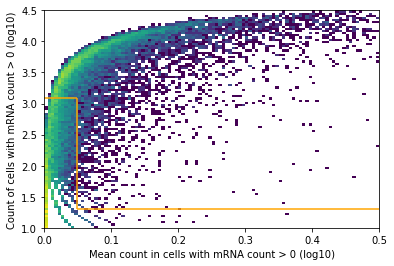

In [6]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [7]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(40532, 12844)

Filter the object:

In [8]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

Add counts matrix as `adata.raw` 

In [9]:
adata_snrna_raw.raw = adata_snrna_raw

## 3. Show UMAP of cells <a name="3.-Show-UMAP-of-cells"></a>

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

In [10]:
#########################
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
sc.pp.log1p(adata_snrna_raw)

sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw.obsm['X_pca'] = adata_snrna_raw.obsm['X_pca'][:, 1:]
adata_snrna_raw.varm['PCs'] = adata_snrna_raw.varm['PCs'][:, 1:]
#########################

# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments) 
import bbknn
bbknn.bbknn(adata_snrna_raw, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 79)
sc.tl.umap(adata_snrna_raw, min_dist = 0.8, spread = 1.5)

#########################

adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].argsort(),:]

Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


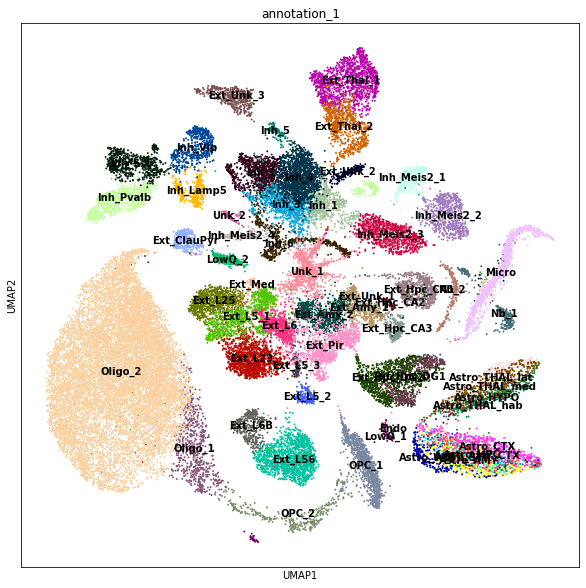

In [11]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).


![Model diagram](../images/Regression_model_diagram.png)  

Also see https://cell2location.readthedocs.io/en/latest/cell2location.regression_models.html#regressiongenebackgroundcoveragegenetechnologytorch

```python
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)
```

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

### Creating model ### - time 0.04 min
### Analysis name: RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12844genes
### Training model to determine n_epochs with CV ###


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

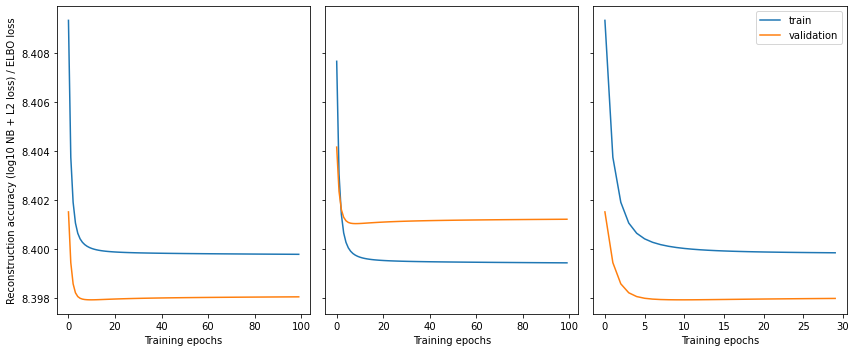

### Re-training model to stop before overfitting ###


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

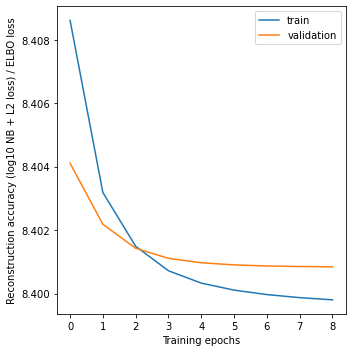

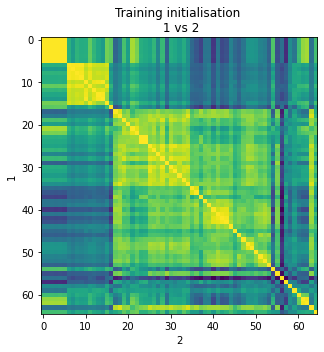

### Evaluating parameters / sampling posterior ### - time 8.05 min


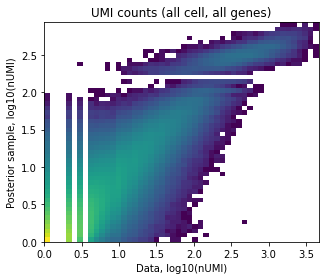

### Saving results ###
### Plotting results ###


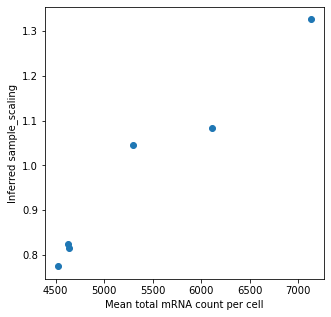

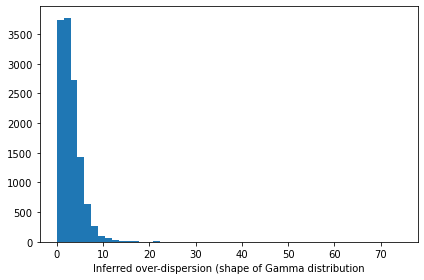

### Done ### - time 9.2 min


In [12]:
# Run the pipeline:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, # input data object]
                   
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], # column listing cell type annotation
                    'sample_name_col': 'sample', # column listing sample ID for each cell
                    
                    # column listing technology, e.g. 3' vs 5', 
                    # when integrating multiple single cell technologies corresponding 
                    # model is automatically selected
                    'tech_name_col': None, 
                    
                    'stratify_cv': 'annotation_1', # stratify cross-validation by cell type annotation
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_cuda': True, # use GPU?
                       
                    'train_proportion': 0.9, # proportion of cells in the training set (for cross-validation)
                    'l2_weight': True,  # uses defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={}, # keep defaults
                   posterior_args={}, # keep defaults
                                 
                   export_args={'path': results_folder + 'regression_model/', # where to save results
                                'save_model': True, # save pytorch model?
                                'run_name_suffix': ''})

reg_mod = r['mod']

Saved anndata object and the trained model object can be read later using:
    
```python
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
## model
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']
```

Export reference expression signatures of cell types:

In [13]:
# Export cell type expression signatures:
covariate_col_names = 'annotation_1'

inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Compare estimated signatures (y-axis) to analytically computed mean expression (x-axis):

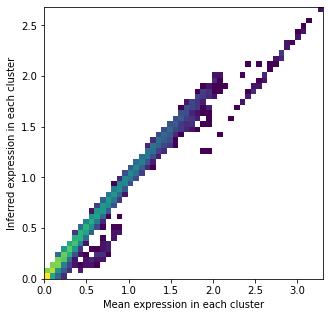

In [14]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, covariate_col_names)
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# compare estimated signatures (y-axis) to analytically computed mean expression (x-axis)
with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

Evaluate whether estimated signatures are less correlated because the confounding sample background is now removed:

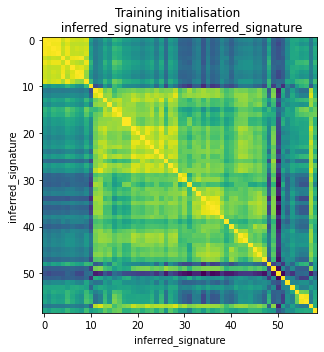

In [15]:
# Look at how correlated are the signatures obtained by computing mean expression
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

# Look at how correlated are the signatures inferred by regression model - they should be less correlated than above
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_signature', 'inferred_signature', align=False)

Compare cell count per experiment to estimated background (soup, free-floating RNA):

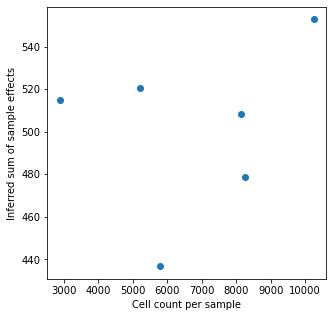

In [16]:
# Examine how many mRNA per cell on average are background 
sample_name_col = 'sample'
cell_count = adata_snrna_raw.obs[sample_name_col].value_counts()
cell_count.index = [f'means_sample_effect{sample_name_col}_{i}' for i in cell_count.index] 
soup_amount = reg_mod.sample_effects.sum(0) 

with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.scatter(cell_count[soup_amount.index].values.flatten(),
                soup_amount.values.flatten());
    plt.xlabel('Cell count per sample'); # fraction of reads in cells
    plt.ylabel('Inferred sum of sample effects');

Supply reference expression signatures to cell2location model (see next notebook):

```python
# Use `inf_aver` for cell2location mapping:
cell2location.run_cell2location(sc_data=inf_aver, ...)
```

## 5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow <a name="5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow"></a>

This allows to identify if the model successfully accounted for technical factor by checking whether removing contribution those factors from every single cell leads to merging of samples / batches, yet preserves well-separated cell types in the UMAP space.

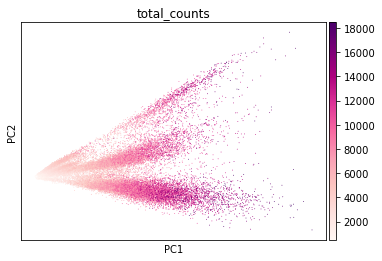

In [17]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
del adata_snrna_raw_cor.uns['log1p']

adata_snrna_raw_cor.X = np.array(reg_mod.normalise(adata_snrna_raw_cor.raw.X.copy()))

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
# when all RNA of a given gene are additive background this results in NaN after scaling
adata_snrna_raw_cor.X[np.isnan(adata_snrna_raw_cor.X)] = 0
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=80, use_highly_variable=False)

adata_snrna_raw.obs['total_counts'] = np.array(adata_snrna_raw.raw.X.sum(1)).flatten()
adata_snrna_raw_cor.obs['total_counts'] = adata_snrna_raw.obs['total_counts'].values.copy()

sc.pl.pca(adata_snrna_raw_cor, color=['total_counts'],
          components=['1,2'],
          color_map = 'RdPu', ncols = 2, legend_loc='on data', vmax='p99.9',
          legend_fontsize=10)

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw_cor.obsm['X_pca'] = adata_snrna_raw_cor.obsm['X_pca'][:, 1:]
adata_snrna_raw_cor.varm['PCs'] = adata_snrna_raw_cor.varm['PCs'][:, 1:]

# here we use standard neighbors function rather than bbknn 
# to show that the regression model can merge batches / experiments
sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 79, metric='cosine')
sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.8, spread = 1)

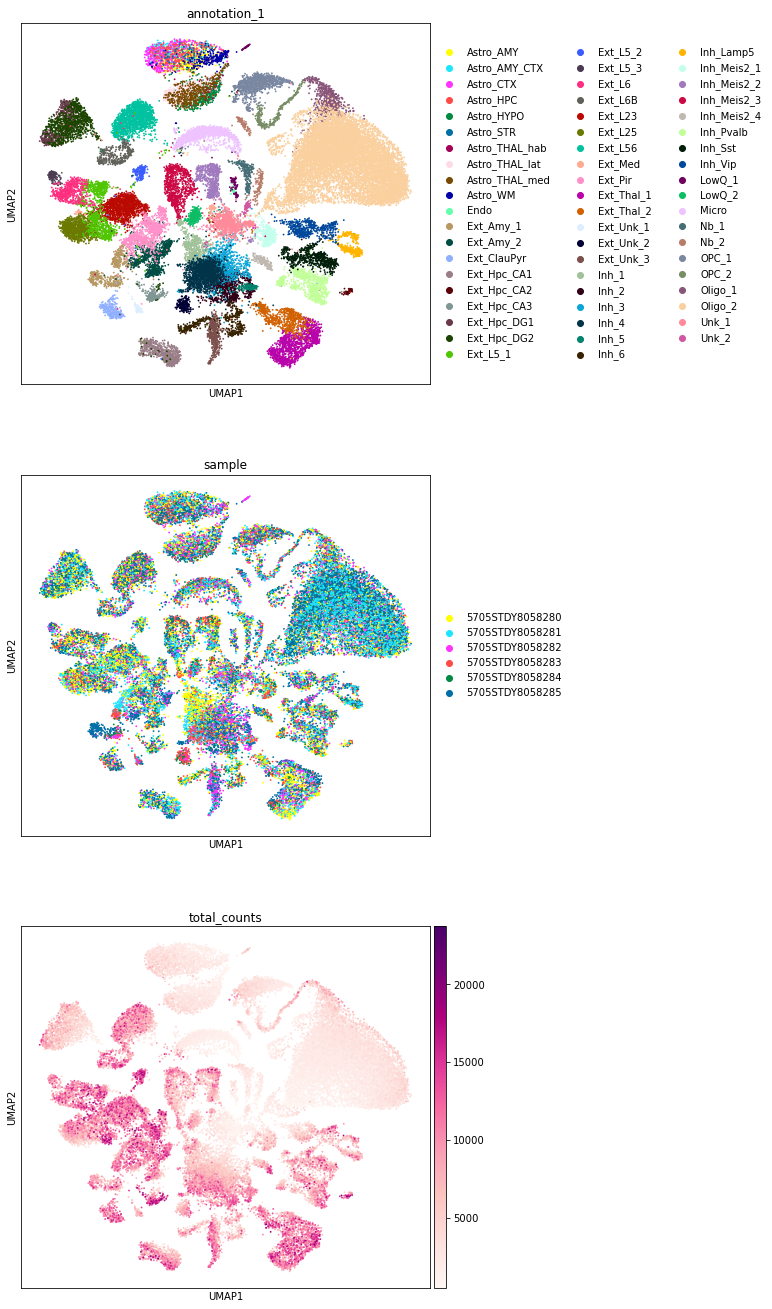

In [18]:
with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw_cor, color=['annotation_1', 'sample', 'total_counts'],
               color_map = 'RdPu', ncols = 1, size=13, #legend_loc='on data',
               legend_fontsize=10, palette=sc.pl.palettes.default_102)

Modules and their versions used for this analysis

In [19]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 6.2.0
ipykernel._version 6.2.0
json 2.0.9
re 2.2.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
zlib 1.0
platform 1.0.8
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.2.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.2.1
zmq.sugar.constants 40304
zmq.sugar.version 22.2.1
traitlets 5.0.5
traitlets._version 5.0.5
logging 0.5.1.2
argparse 1.1
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
colorama 0.4.4
_curses b'2.2'
IPython 7.26.0
IPython.core.release 7.26.0
IPython.core.crashhandler 7.26.0
pygments 2.10.0
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.9
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.19
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
IPython.core.magics.code 7.26.0
urllib.request 3.7
dateutil 2.8.2
dateutil._version 2.8.2
six 1.16.0
decimal 1.70
_d